# **Exact Diagonalization on the One-Dimensional Clock Model**

### Code

In [3]:
import scipy.sparse.linalg as spla
import scipy.sparse as sp
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import namedtuple

In [4]:
# Define operators
def clock_operators(q):
    """
    Define clock model operators for q-state system.
    
    Parameters:
    q: number of discrete states

    Returns:
    Clock and shift operator.
    """
    omega =  np.exp((2j * np.pi) / q)
    C = sp.csr_matrix(np.diag([omega ** m for m in range(q)]))
    S = sp.csr_matrix(np.roll(np.eye(q), shift=-1, axis=1))
    
    return C, S

def apply_operator_at_site(O, i, L, q):
    """
    Places an operator O at site i in an L-site q-state system.

    Parameters:
    O: operator to apply
    i: state index
    L: total number of sites
    q: number of discrete states per site

    Returns:
    The Kronecker product representing the operator acting on the full system.
    """
    L = int(L)
    if not (0 <= i < L):
        raise IndexError(f"Invalid site index i={i}. Must be between 0 and {L-1}")

    I_q = sp.identity(q, format="csr")
    op_list = [I_q] * L  # List of identity operators
    op_list[i] = O  # Apply operator at correct site

    # Compute the full Kronecker product
    full_operator = op_list[0]
    for op in op_list[1:]:
        full_operator = sp.kron(full_operator, op, format="csr")

    return full_operator

In [5]:
# Define Hamiltonian
def clock_hamiltonian(q, J, h, L):
    """
    Parameters:
    q: number of discrete states
    C: clock operator
    S: shift operator
    J: coupling constant
    h: external field strength
    L: number of sites
    """
    L = int(L)

    C, S = clock_operators(q)
    H = sp.csr_matrix((q**L, q**L))

    for i in range(1, L):
        H += (-J) * ((apply_operator_at_site(S, i-1, L, q) @ apply_operator_at_site(S.H, i, L, q)) 
             + (apply_operator_at_site(S.H, i-1, L, q) @ apply_operator_at_site(S, i, L, q)))
        H += (-J * (h / (2 * J))) * (apply_operator_at_site(C, i-1, L, q) + apply_operator_at_site(C.H, i-1, L, q) 
                                     + apply_operator_at_site(C, i, L, q) + apply_operator_at_site(C.H, i, L, q))

    # Apply periodic boundary condition
    H += (-J) * ((apply_operator_at_site(S, L-1, L, q) @ apply_operator_at_site(S.H, 0, L, q)) 
                                 + (apply_operator_at_site(S.H, L-1, L, q) @ apply_operator_at_site(S, 0, L, q)))
    H += (-J * (h / (2 * J))) * (apply_operator_at_site(C, 0, L, q) + apply_operator_at_site(C.H, 0, L, q) 
                                 + apply_operator_at_site(C, L-1, L, q) + apply_operator_at_site(C.H, L-1, L, q))
    return H

In [6]:
# Exact diagonalization
def E0_per_site(q, J, h, L):
    H = clock_hamiltonian(q, J, h, L)
    eigval = spla.eigsh(H, k=1, which='SA', return_eigenvectors=False)  # Use eigsh for real Hermitian
    E0 = np.real(eigval[0])
    return E0 / L

In [7]:
# Exact diagonalization
def E0_and_E1_per_site(q, J, h, L):
    H = clock_hamiltonian(q, J, h, L)
    eigval = spla.eigsh(H, k=2, which='SA', return_eigenvectors=False)  # Use eigsh for real Hermitian
    E0 = np.real(eigval[0])
    E1 = np.real(eigval[1])
    return np.abs(E1 - E0) / L

In [71]:
q = 3  # Number of discrete states per site
h = 1.0  # External field
J = 1.0  # Coupling constant
L = 10  # Number of sites

start_time = time.time()
E0 = E0_per_site(q, J, h, L)
print(f"Ground-state energy per site: {E0}")
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

Ground-state energy per site: -2.446913313245589
Total runtime: 1.57 seconds


In [9]:
q = 3  # Number of discrete states per site
h = 0.5  # External field
J = 1.0  # Coupling constant
L = 10  # Number of sites

start_time = time.time()
E1_minus_E0 = E0_and_E1_per_site(q, J, h, L)
print(f"Energy gap per site: {E1_minus_E0}")
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

Energy gap per site: 5.6062131548628715e-06
Total runtime: 1.02 seconds


Extrapolated E/L (L -> ∞): 2.546959
Scaling parameters: b = 1.191567, c = 2.081967


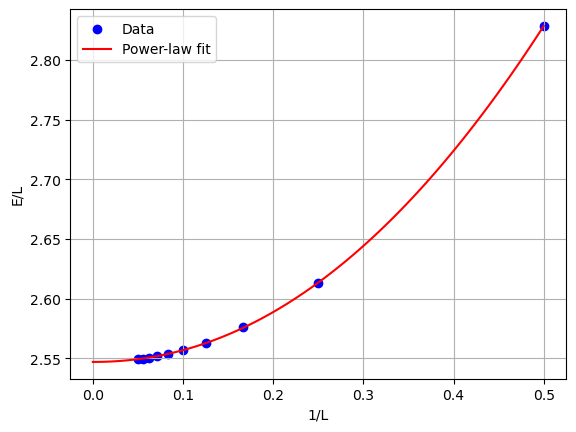

In [10]:
from scipy.optimize import curve_fit

q = 2
J = 1
h = 1
L_values = np.array([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])

# Define the power-law fit function
def power_law(L_inv, a, b, c):
    return a + b * (L_inv**c)

inv_L = 1 / L_values

energies_per_L = []

for L in L_values:
    energies = E0_per_site(q, J, h, L)
    energies_per_L.append(np.abs(energies))

# Fit the power-law function to the data
popt, pcov = curve_fit(power_law, inv_L, energies_per_L, p0=[-2, 1, 1])  # Initial guesses

# Extract fitted parameters
a_fit, b_fit, c_fit = popt
print(f"Extrapolated E/L (L -> ∞): {a_fit:.6f}")
print(f"Scaling parameters: b = {b_fit:.6f}, c = {c_fit:.6f}")

# Plot the original data and fitted curve
plt.scatter(inv_L, energies_per_L, color='blue', label="Data")
L_inv_fine = np.linspace(0, max(inv_L), 100)  # Fine grid for smooth curve
plt.plot(L_inv_fine, power_law(L_inv_fine, *popt), color='red', label="Power-law fit")

plt.xlabel("1/L")
plt.ylabel("E/L")
plt.legend()
plt.grid(True)
plt.show()

### Plots (Ground-State Energy per Site)

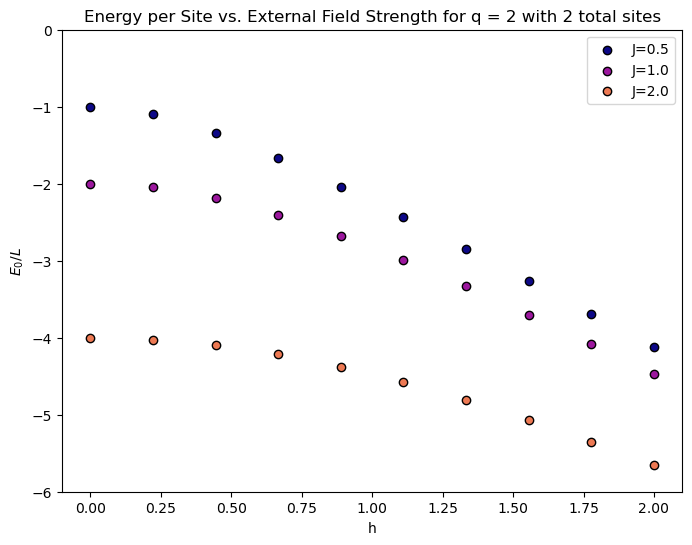

Total runtime: 1.61 seconds


In [12]:
# Parameters
L = 2
q = 2
J_values = [0.5, 1.0, 2.0]
h_values = np.linspace(0, 2, 10)  # Range of h values

start_time = time.time()

# Total unique combinations
total_combinations = len(J_values)

plt.figure(figsize = (8, 6))
# Get colormap and generate distinct colors
cmap = plt.colormaps.get_cmap("plasma")  # Get colormap
colors = [cmap(i / total_combinations) for i in range(total_combinations)]  # Generate unique colors

index = 0  # Color index tracker
for J in J_values:
    energies = [E0_per_site(q, J, h, L) for h in h_values]
    plt.scatter(h_values, energies, color=colors[index], edgecolors="black", label=f"J={J}")
    index += 1  # Move to the next color

plt.xlabel("h")
plt.ylabel("$E_{0} / L$")
plt.title(f"Energy per Site vs. External Field Strength for q = {q} with {L} total sites")
plt.ylim(-6, 0)
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.show()
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

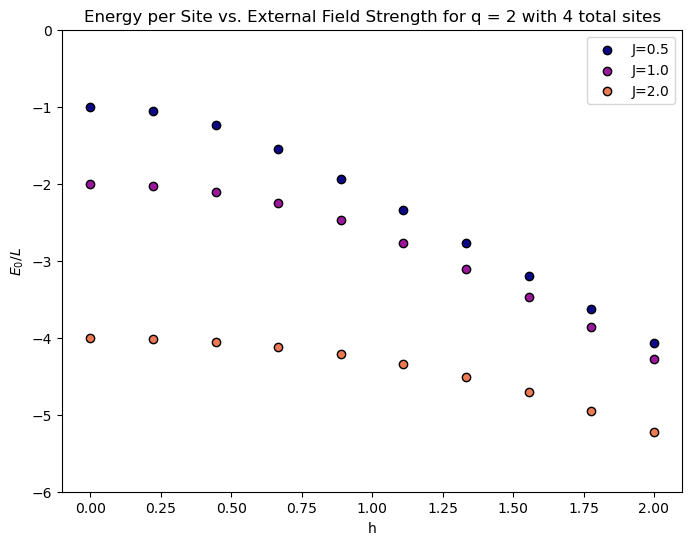

Total runtime: 3.60 seconds


In [13]:
# Parameters
L = 4
q = 2
J_values = [0.5, 1.0, 2.0]
h_values = np.linspace(0, 2, 10)  # Range of h values

start_time = time.time()

# Total unique combinations
total_combinations = len(J_values)

plt.figure(figsize = (8, 6))
# Get colormap and generate distinct colors
cmap = plt.colormaps.get_cmap("plasma")  # Get colormap
colors = [cmap(i / total_combinations) for i in range(total_combinations)]  # Generate unique colors

index = 0  # Color index tracker
for J in J_values:
    energies = [E0_per_site(q, J, h, L) for h in h_values]
    plt.scatter(h_values, energies, color=colors[index], edgecolors="black", label=f"J={J}")
    index += 1  # Move to the next color

plt.xlabel("h")
plt.ylabel("$E_{0} / L$")
plt.title(f"Energy per Site vs. External Field Strength for q = {q} with {L} total sites")
plt.ylim(-6, 0)
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.show()
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

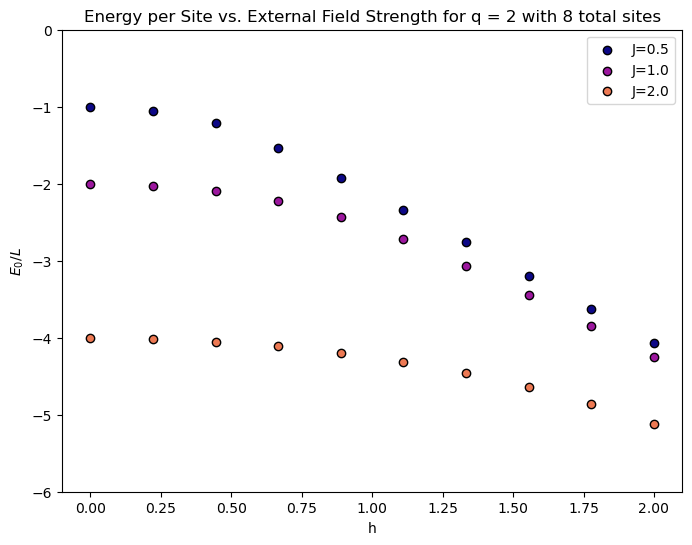

Total runtime: 13.49 seconds


In [14]:
# Parameters
L = 8
q = 2
J_values = [0.5, 1.0, 2.0]
h_values = np.linspace(0, 2, 10)  # Range of h values

start_time = time.time()

# Total unique combinations
total_combinations = len(J_values)

plt.figure(figsize = (8, 6))
# Get colormap and generate distinct colors
cmap = plt.colormaps.get_cmap("plasma")  # Get colormap
colors = [cmap(i / total_combinations) for i in range(total_combinations)]  # Generate unique colors

index = 0  # Color index tracker
for J in J_values:
    energies = [E0_per_site(q, J, h, L) for h in h_values]
    plt.scatter(h_values, energies, color=colors[index], edgecolors="black", label=f"J={J}")
    index += 1  # Move to the next color

plt.xlabel("h")
plt.ylabel("$E_{0} / L$")
plt.title(f"Energy per Site vs. External Field Strength for q = {q} with {L} total sites")
plt.ylim(-6, 0)
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.show()
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

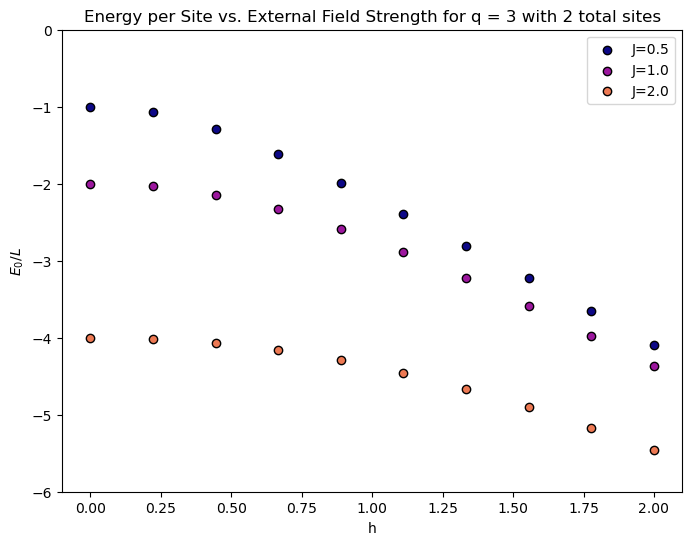

Total runtime: 1.26 seconds


In [15]:
# Parameters
L = 2
q = 3
J_values = [0.5, 1.0, 2.0]
h_values = np.linspace(0, 2, 10)  # Range of h values

start_time = time.time()

# Total unique combinations
total_combinations = len(J_values)

plt.figure(figsize = (8, 6))
# Get colormap and generate distinct colors
cmap = plt.colormaps.get_cmap("plasma")  # Get colormap
colors = [cmap(i / total_combinations) for i in range(total_combinations)]  # Generate unique colors

index = 0  # Color index tracker
for J in J_values:
    energies = [E0_per_site(q, J, h, L) for h in h_values]
    plt.scatter(h_values, energies, color=colors[index], edgecolors="black", label=f"J={J}")
    index += 1  # Move to the next color

plt.xlabel("h")
plt.ylabel("$E_{0} / L$")
plt.title(f"Energy per Site vs. External Field Strength for q = {q} with {L} total sites")
plt.ylim(-6, 0)
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.show()
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

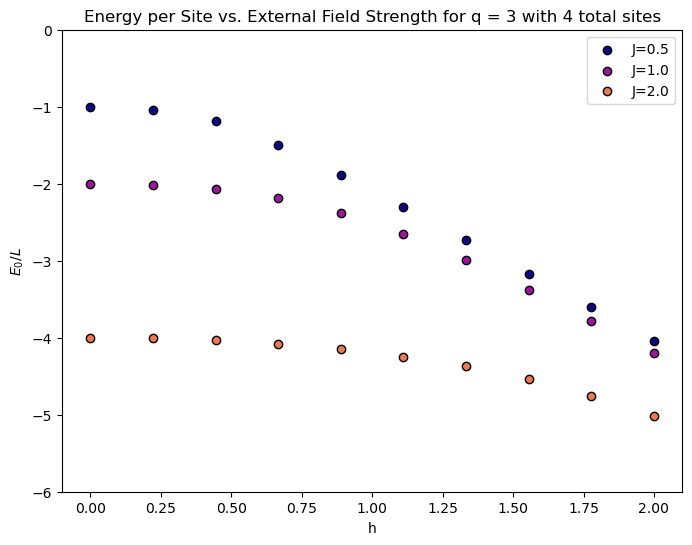

Total runtime: 3.66 seconds


In [16]:
# Parameters
L = 4
q = 3
J_values = [0.5, 1.0, 2.0]
h_values = np.linspace(0, 2, 10)  # Range of h values

start_time = time.time()

# Total unique combinations
total_combinations = len(J_values)

plt.figure(figsize = (8, 6))
# Get colormap and generate distinct colors
cmap = plt.colormaps.get_cmap("plasma")  # Get colormap
colors = [cmap(i / total_combinations) for i in range(total_combinations)]  # Generate unique colors

index = 0  # Color index tracker
for J in J_values:
    energies = [E0_per_site(q, J, h, L) for h in h_values]
    plt.scatter(h_values, energies, color=colors[index], edgecolors="black", label=f"J={J}")
    index += 1  # Move to the next color

plt.xlabel("h")
plt.ylabel("$E_{0} / L$")
plt.title(f"Energy per Site vs. External Field Strength for q = {q} with {L} total sites")
plt.ylim(-6, 0)
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.show()
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

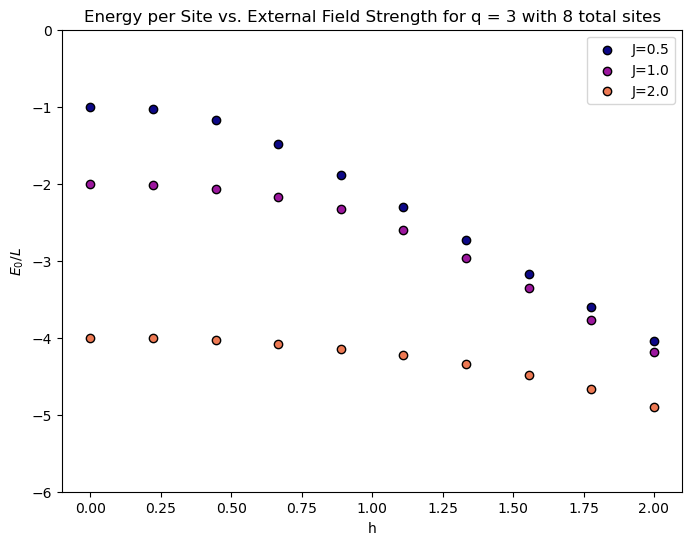

Total runtime: 19.73 seconds


In [17]:
# Parameters
L = 8
q = 3
J_values = [0.5, 1.0, 2.0]
h_values = np.linspace(0, 2, 10)  # Range of h values

start_time = time.time()

# Total unique combinations
total_combinations = len(J_values)

plt.figure(figsize = (8, 6))
# Get colormap and generate distinct colors
cmap = plt.colormaps.get_cmap("plasma")  # Get colormap
colors = [cmap(i / total_combinations) for i in range(total_combinations)]  # Generate unique colors

index = 0  # Color index tracker
for J in J_values:
    energies = [E0_per_site(q, J, h, L) for h in h_values]
    plt.scatter(h_values, energies, color=colors[index], edgecolors="black", label=f"J={J}")
    index += 1  # Move to the next color

plt.xlabel("h")
plt.ylabel("$E_{0} / L$")
plt.title(f"Energy per Site vs. External Field Strength for q = {q} with {L} total sites")
plt.ylim(-6, 0)
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.show()
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

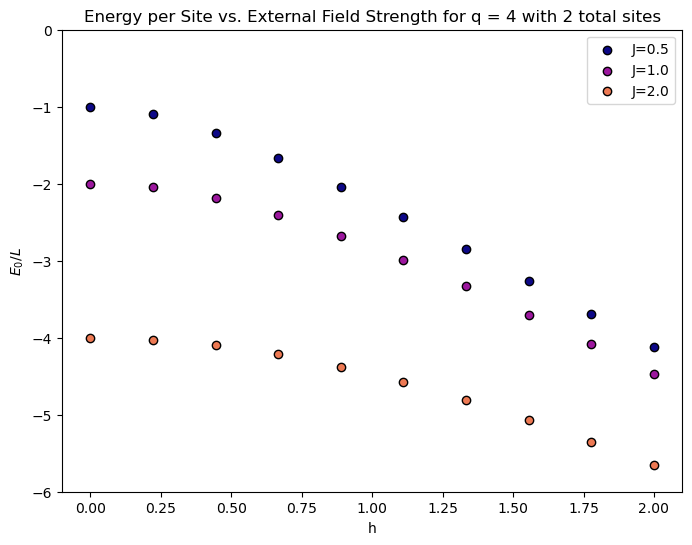

Total runtime: 1.26 seconds


In [18]:
# Parameters
L = 2
q = 4
J_values = [0.5, 1.0, 2.0]
h_values = np.linspace(0, 2, 10)  # Range of h values

start_time = time.time()

# Total unique combinations
total_combinations = len(J_values)

plt.figure(figsize = (8, 6))
# Get colormap and generate distinct colors
cmap = plt.colormaps.get_cmap("plasma")  # Get colormap
colors = [cmap(i / total_combinations) for i in range(total_combinations)]  # Generate unique colors

index = 0  # Color index tracker
for J in J_values:
    energies = [E0_per_site(q, J, h, L) for h in h_values]
    plt.scatter(h_values, energies, color=colors[index], edgecolors="black", label=f"J={J}")
    index += 1  # Move to the next color

plt.xlabel("h")
plt.ylabel("$E_{0} / L$")
plt.title(f"Energy per Site vs. External Field Strength for q = {q} with {L} total sites")
plt.ylim(-6, 0)
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.show()
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

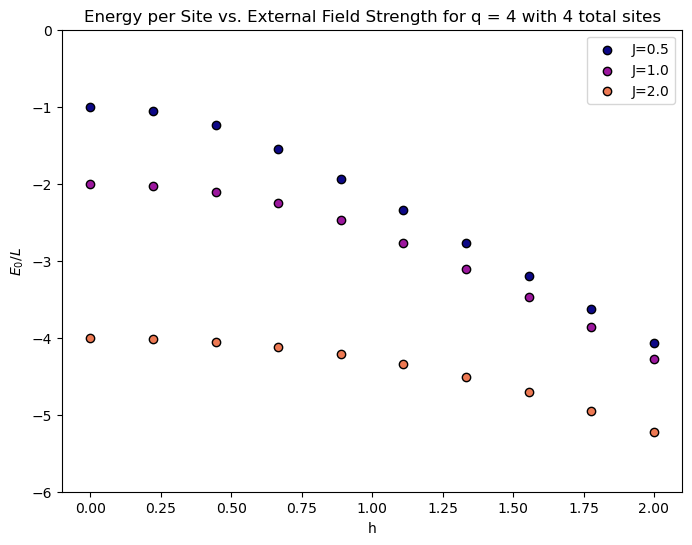

Total runtime: 3.78 seconds


In [19]:
# Parameters
L = 4
q = 4
J_values = [0.5, 1.0, 2.0]
h_values = np.linspace(0, 2, 10)  # Range of h values

start_time = time.time()

# Total unique combinations
total_combinations = len(J_values)

plt.figure(figsize = (8, 6))
# Get colormap and generate distinct colors
cmap = plt.colormaps.get_cmap("plasma")  # Get colormap
colors = [cmap(i / total_combinations) for i in range(total_combinations)]  # Generate unique colors

index = 0  # Color index tracker
for J in J_values:
    energies = [E0_per_site(q, J, h, L) for h in h_values]
    plt.scatter(h_values, energies, color=colors[index], edgecolors="black", label=f"J={J}")
    index += 1  # Move to the next color

plt.xlabel("h")
plt.ylabel("$E_{0} / L$")
plt.title(f"Energy per Site vs. External Field Strength for q = {q} with {L} total sites")
plt.ylim(-6, 0)
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.show()
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

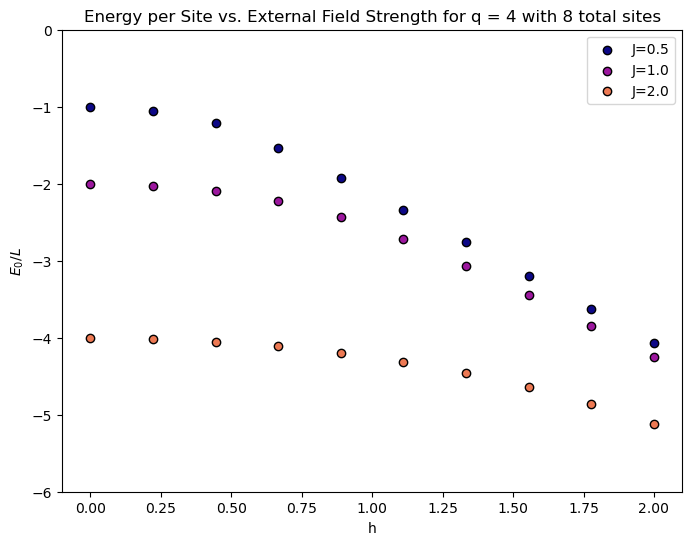

Total runtime: 94.17 seconds


In [20]:
# Parameters
L = 8
q = 4
J_values = [0.5, 1.0, 2.0]
h_values = np.linspace(0, 2, 10)  # Range of h values

start_time = time.time()

# Total unique combinations
total_combinations = len(J_values)

plt.figure(figsize = (8, 6))
# Get colormap and generate distinct colors
cmap = plt.colormaps.get_cmap("plasma")  # Get colormap
colors = [cmap(i / total_combinations) for i in range(total_combinations)]  # Generate unique colors

index = 0  # Color index tracker
for J in J_values:
    energies = [E0_per_site(q, J, h, L) for h in h_values]
    plt.scatter(h_values, energies, color=colors[index], edgecolors="black", label=f"J={J}")
    index += 1  # Move to the next color

plt.xlabel("h")
plt.ylabel("$E_{0} / L$")
plt.title(f"Energy per Site vs. External Field Strength for q = {q} with {L} total sites")
plt.ylim(-6, 0)
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.show()
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

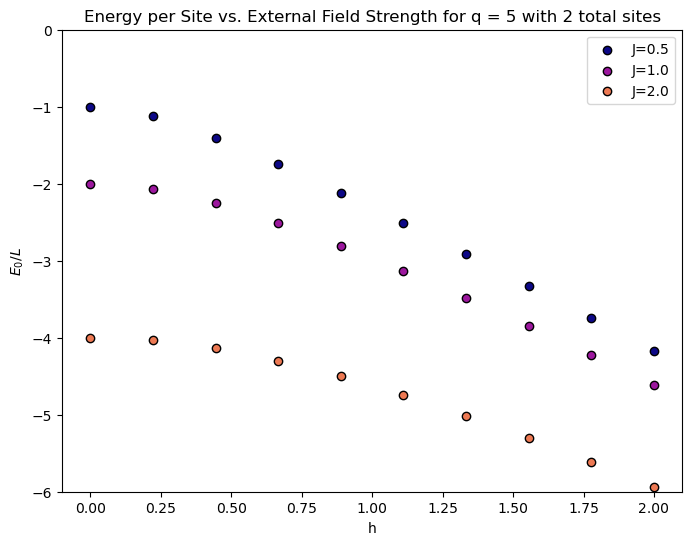

Total runtime: 1.46 seconds


In [21]:
# Parameters
L = 2
q = 5
J_values = [0.5, 1.0, 2.0]
h_values = np.linspace(0, 2, 10)  # Range of h values

start_time = time.time()

# Total unique combinations
total_combinations = len(J_values)

plt.figure(figsize = (8, 6))
# Get colormap and generate distinct colors
cmap = plt.colormaps.get_cmap("plasma")  # Get colormap
colors = [cmap(i / total_combinations) for i in range(total_combinations)]  # Generate unique colors

index = 0  # Color index tracker
for J in J_values:
    energies = [E0_per_site(q, J, h, L) for h in h_values]
    plt.scatter(h_values, energies, color=colors[index], edgecolors="black", label=f"J={J}")
    index += 1  # Move to the next color

plt.xlabel("h")
plt.ylabel("$E_{0} / L$")
plt.title(f"Energy per Site vs. External Field Strength for q = {q} with {L} total sites")
plt.ylim(-6, 0)
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.show()
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

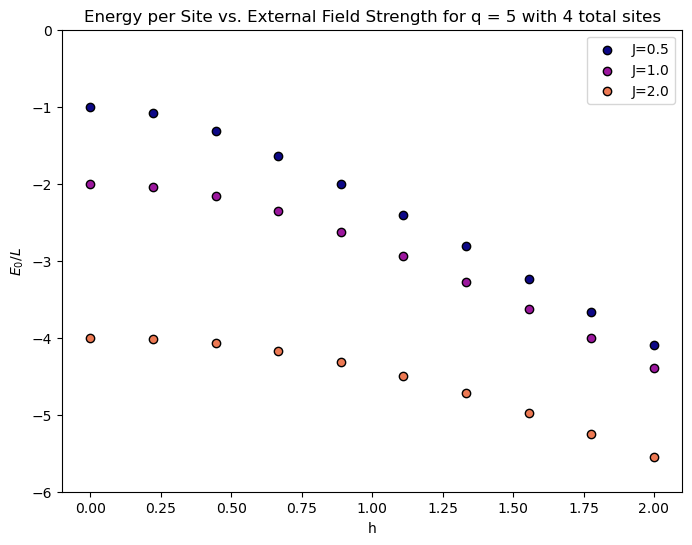

Total runtime: 3.98 seconds


In [22]:
# Parameters
L = 4
q = 5
J_values = [0.5, 1.0, 2.0]
h_values = np.linspace(0, 2, 10)  # Range of h values

start_time = time.time()

# Total unique combinations
total_combinations = len(J_values)

plt.figure(figsize = (8, 6))
# Get colormap and generate distinct colors
cmap = plt.colormaps.get_cmap("plasma")  # Get colormap
colors = [cmap(i / total_combinations) for i in range(total_combinations)]  # Generate unique colors

index = 0  # Color index tracker
for J in J_values:
    energies = [E0_per_site(q, J, h, L) for h in h_values]
    plt.scatter(h_values, energies, color=colors[index], edgecolors="black", label=f"J={J}")
    index += 1  # Move to the next color

plt.xlabel("h")
plt.ylabel("$E_{0} / L$")
plt.title(f"Energy per Site vs. External Field Strength for q = {q} with {L} total sites")
plt.ylim(-6, 0)
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.show()
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

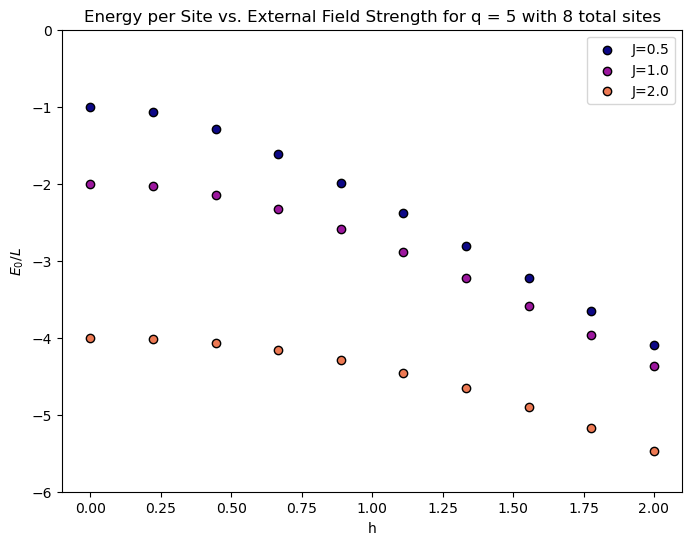

Total runtime: 563.38 seconds


In [23]:
# Parameters
L = 8
q = 5
J_values = [0.5, 1.0, 2.0]
h_values = np.linspace(0, 2, 10)  # Range of h values

start_time = time.time()

# Total unique combinations
total_combinations = len(J_values)

plt.figure(figsize = (8, 6))
# Get colormap and generate distinct colors
cmap = plt.colormaps.get_cmap("plasma")  # Get colormap
colors = [cmap(i / total_combinations) for i in range(total_combinations)]  # Generate unique colors

index = 0  # Color index tracker
for J in J_values:
    energies = [E0_per_site(q, J, h, L) for h in h_values]
    plt.scatter(h_values, energies, color=colors[index], edgecolors="black", label=f"J={J}")
    index += 1  # Move to the next color

plt.xlabel("h")
plt.ylabel("$E_{0} / L$")
plt.title(f"Energy per Site vs. External Field Strength for q = {q} with {L} total sites")
plt.ylim(-6, 0)
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.show()
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

### Plots (Energy Gap per Site)

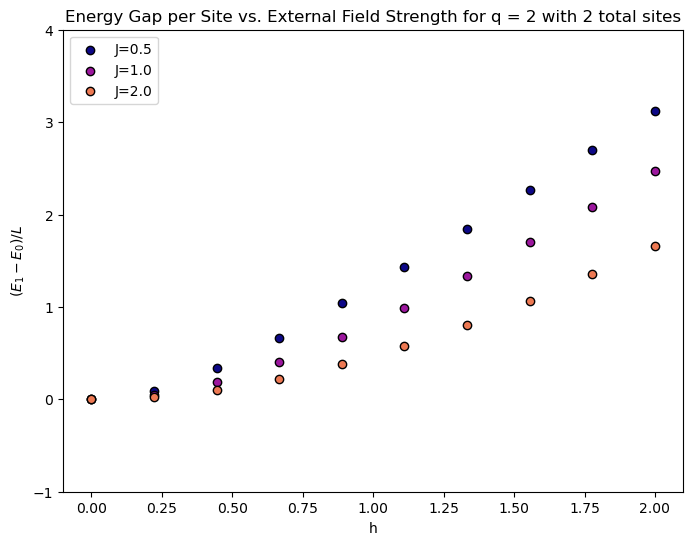

Total runtime: 1.24 seconds


In [25]:
# Parameters
L = 2
q = 2
J_values = [0.5, 1.0, 2.0]
h_values = np.linspace(0, 2, 10)  # Range of h values

start_time = time.time()

# Total unique combinations
total_combinations = len(J_values)

plt.figure(figsize = (8, 6))
# Get colormap and generate distinct colors
cmap = plt.colormaps.get_cmap("plasma")  # Get colormap
colors = [cmap(i / total_combinations) for i in range(total_combinations)]  # Generate unique colors

index = 0  # Color index tracker
for J in J_values:
    energies = [E0_and_E1_per_site(q, J, h, L) for h in h_values]
    plt.scatter(h_values, energies, color=colors[index], edgecolors="black", label=f"J={J}")
    index += 1  # Move to the next color

plt.xlabel("h")
plt.ylabel("$(E_{1} - E_{0})/ L$")
plt.title(f"Energy Gap per Site vs. External Field Strength for q = {q} with {L} total sites")
plt.ylim(-1, 4)
plt.legend(loc="upper left", bbox_to_anchor=(0, 1))
plt.show()
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

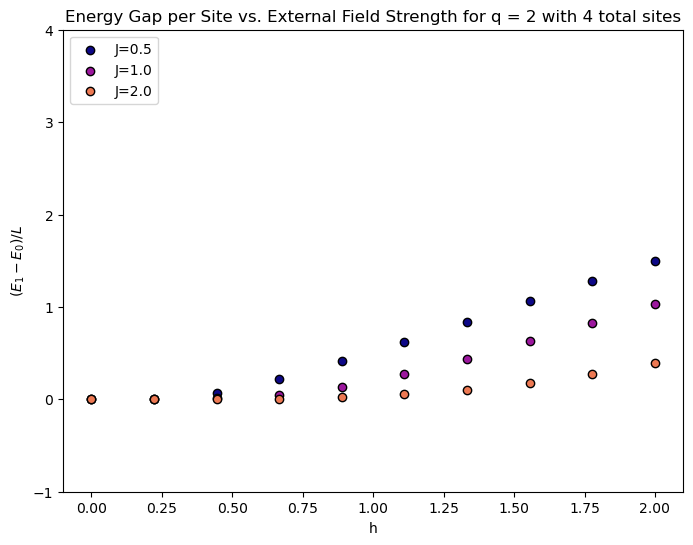

Total runtime: 3.66 seconds


In [26]:
# Parameters
L = 4
q = 2
J_values = [0.5, 1.0, 2.0]
h_values = np.linspace(0, 2, 10)  # Range of h values

start_time = time.time()

# Total unique combinations
total_combinations = len(J_values)

plt.figure(figsize = (8, 6))
# Get colormap and generate distinct colors
cmap = plt.colormaps.get_cmap("plasma")  # Get colormap
colors = [cmap(i / total_combinations) for i in range(total_combinations)]  # Generate unique colors

index = 0  # Color index tracker
for J in J_values:
    energies = [E0_and_E1_per_site(q, J, h, L) for h in h_values]
    plt.scatter(h_values, energies, color=colors[index], edgecolors="black", label=f"J={J}")
    index += 1  # Move to the next color

plt.xlabel("h")
plt.ylabel("$(E_{1} - E_{0})/ L$")
plt.title(f"Energy Gap per Site vs. External Field Strength for q = {q} with {L} total sites")
plt.ylim(-1, 4)
plt.legend(loc="upper left", bbox_to_anchor=(0, 1))
plt.show()
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

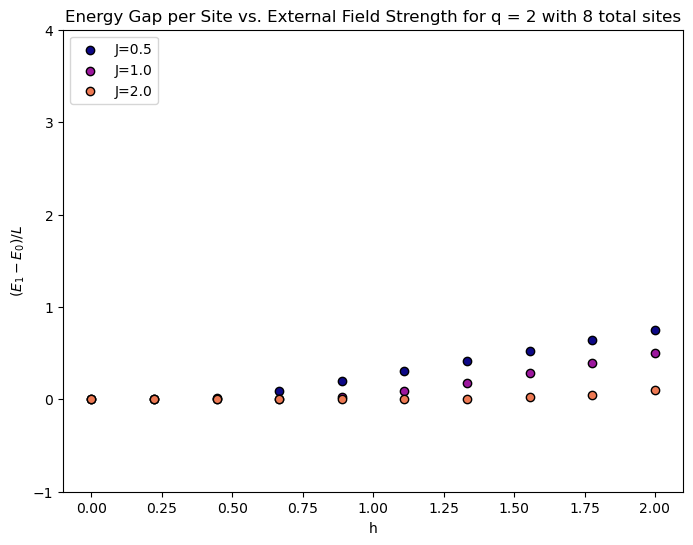

Total runtime: 14.88 seconds


In [27]:
# Parameters
L = 8
q = 2
J_values = [0.5, 1.0, 2.0]
h_values = np.linspace(0, 2, 10)  # Range of h values

start_time = time.time()

# Total unique combinations
total_combinations = len(J_values)

plt.figure(figsize = (8, 6))
# Get colormap and generate distinct colors
cmap = plt.colormaps.get_cmap("plasma")  # Get colormap
colors = [cmap(i / total_combinations) for i in range(total_combinations)]  # Generate unique colors

index = 0  # Color index tracker
for J in J_values:
    energies = [E0_and_E1_per_site(q, J, h, L) for h in h_values]
    plt.scatter(h_values, energies, color=colors[index], edgecolors="black", label=f"J={J}")
    index += 1  # Move to the next color

plt.xlabel("h")
plt.ylabel("$(E_{1} - E_{0})/ L$")
plt.title(f"Energy Gap per Site vs. External Field Strength for q = {q} with {L} total sites")
plt.ylim(-1, 4)
plt.legend(loc="upper left", bbox_to_anchor=(0, 1))
plt.show()
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

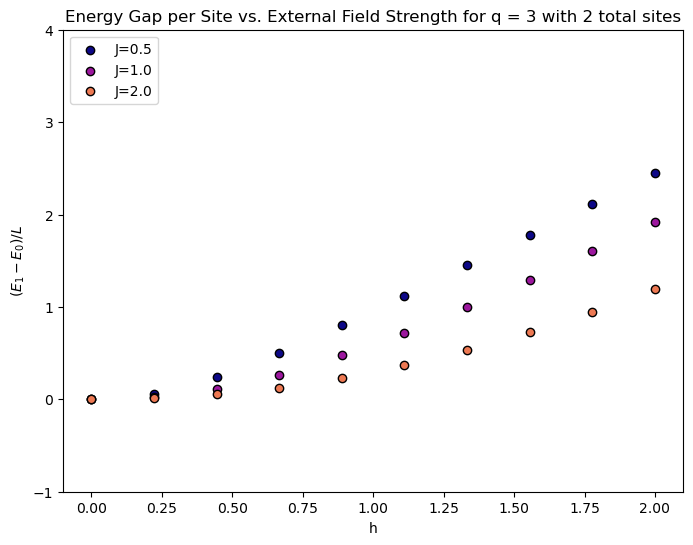

Total runtime: 1.32 seconds


In [28]:
# Parameters
L = 2
q = 3
J_values = [0.5, 1.0, 2.0]
h_values = np.linspace(0, 2, 10)  # Range of h values

start_time = time.time()

# Total unique combinations
total_combinations = len(J_values)

plt.figure(figsize = (8, 6))
# Get colormap and generate distinct colors
cmap = plt.colormaps.get_cmap("plasma")  # Get colormap
colors = [cmap(i / total_combinations) for i in range(total_combinations)]  # Generate unique colors

index = 0  # Color index tracker
for J in J_values:
    energies = [E0_and_E1_per_site(q, J, h, L) for h in h_values]
    plt.scatter(h_values, energies, color=colors[index], edgecolors="black", label=f"J={J}")
    index += 1  # Move to the next color

plt.xlabel("h")
plt.ylabel("$(E_{1} - E_{0})/ L$")
plt.title(f"Energy Gap per Site vs. External Field Strength for q = {q} with {L} total sites")
plt.ylim(-1, 4)
plt.legend(loc="upper left", bbox_to_anchor=(0, 1))
plt.show()
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

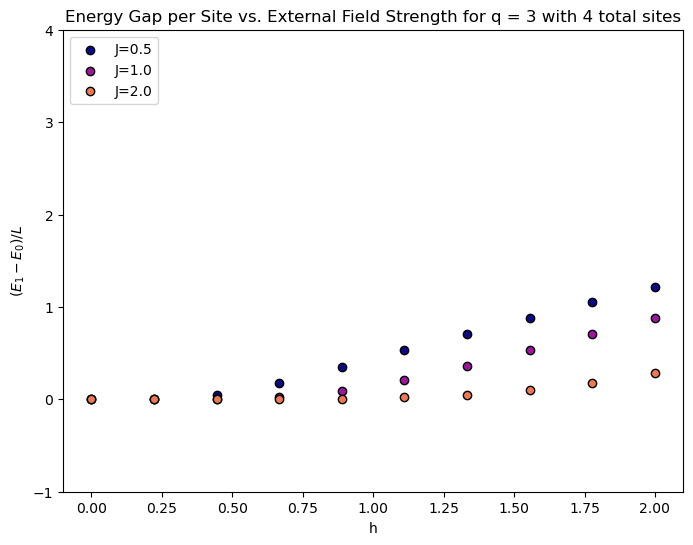

Total runtime: 3.70 seconds


In [29]:
# Parameters
L = 4
q = 3
J_values = [0.5, 1.0, 2.0]
h_values = np.linspace(0, 2, 10)  # Range of h values

start_time = time.time()

# Total unique combinations
total_combinations = len(J_values)

plt.figure(figsize = (8, 6))
# Get colormap and generate distinct colors
cmap = plt.colormaps.get_cmap("plasma")  # Get colormap
colors = [cmap(i / total_combinations) for i in range(total_combinations)]  # Generate unique colors

index = 0  # Color index tracker
for J in J_values:
    energies = [E0_and_E1_per_site(q, J, h, L) for h in h_values]
    plt.scatter(h_values, energies, color=colors[index], edgecolors="black", label=f"J={J}")
    index += 1  # Move to the next color

plt.xlabel("h")
plt.ylabel("$(E_{1} - E_{0})/ L$")
plt.title(f"Energy Gap per Site vs. External Field Strength for q = {q} with {L} total sites")
plt.ylim(-1, 4)
plt.legend(loc="upper left", bbox_to_anchor=(0, 1))
plt.show()
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

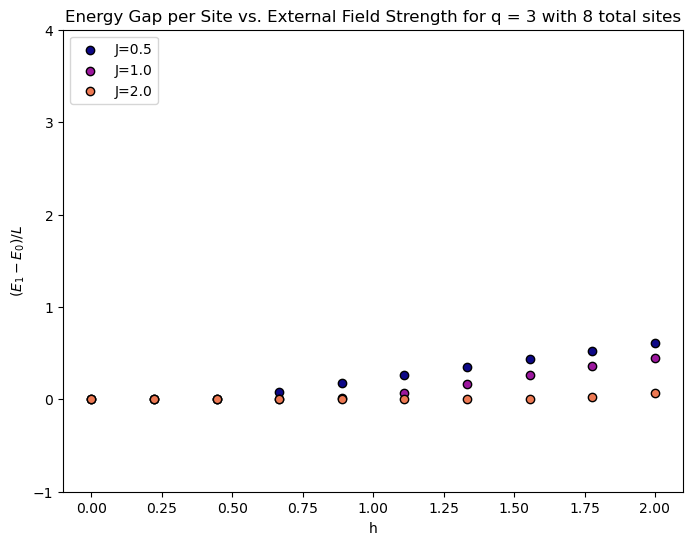

Total runtime: 21.01 seconds


In [30]:
# Parameters
L = 8
q = 3
J_values = [0.5, 1.0, 2.0]
h_values = np.linspace(0, 2, 10)  # Range of h values

start_time = time.time()

# Total unique combinations
total_combinations = len(J_values)

plt.figure(figsize = (8, 6))
# Get colormap and generate distinct colors
cmap = plt.colormaps.get_cmap("plasma")  # Get colormap
colors = [cmap(i / total_combinations) for i in range(total_combinations)]  # Generate unique colors

index = 0  # Color index tracker
for J in J_values:
    energies = [E0_and_E1_per_site(q, J, h, L) for h in h_values]
    plt.scatter(h_values, energies, color=colors[index], edgecolors="black", label=f"J={J}")
    index += 1  # Move to the next color

plt.xlabel("h")
plt.ylabel("$(E_{1} - E_{0})/ L$")
plt.title(f"Energy Gap per Site vs. External Field Strength for q = {q} with {L} total sites")
plt.ylim(-1, 4)
plt.legend(loc="upper left", bbox_to_anchor=(0, 1))
plt.show()
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

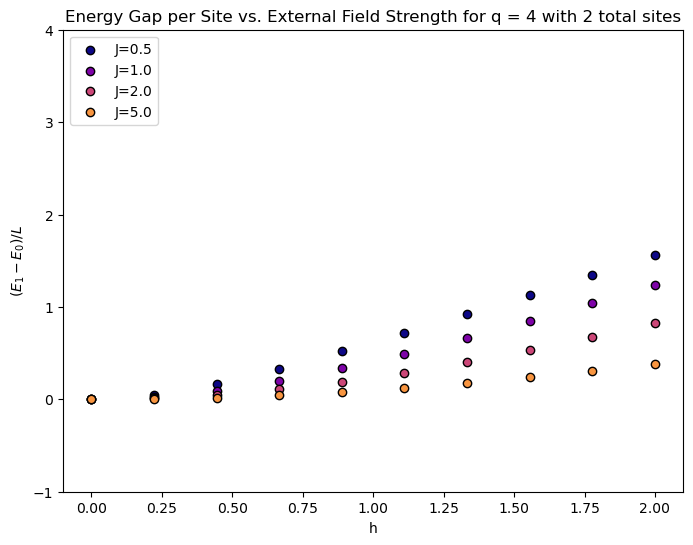

Total runtime: 1.55 seconds


In [31]:
# Parameters
L = 2
q = 4
J_values = [0.5, 1.0, 2.0, 5.0]
h_values = np.linspace(0, 2, 10)  # Range of h values

start_time = time.time()

# Total unique combinations
total_combinations = len(J_values)

plt.figure(figsize = (8, 6))
# Get colormap and generate distinct colors
cmap = plt.colormaps.get_cmap("plasma")  # Get colormap
colors = [cmap(i / total_combinations) for i in range(total_combinations)]  # Generate unique colors

index = 0  # Color index tracker
for J in J_values:
    energies = [E0_and_E1_per_site(q, J, h, L) for h in h_values]
    plt.scatter(h_values, energies, color=colors[index], edgecolors="black", label=f"J={J}")
    index += 1  # Move to the next color

plt.xlabel("h")
plt.ylabel("$(E_{1} - E_{0})/ L$")
plt.title(f"Energy Gap per Site vs. External Field Strength for q = {q} with {L} total sites")
plt.ylim(-1, 4)
plt.legend(loc="upper left", bbox_to_anchor=(0, 1))
plt.show()
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

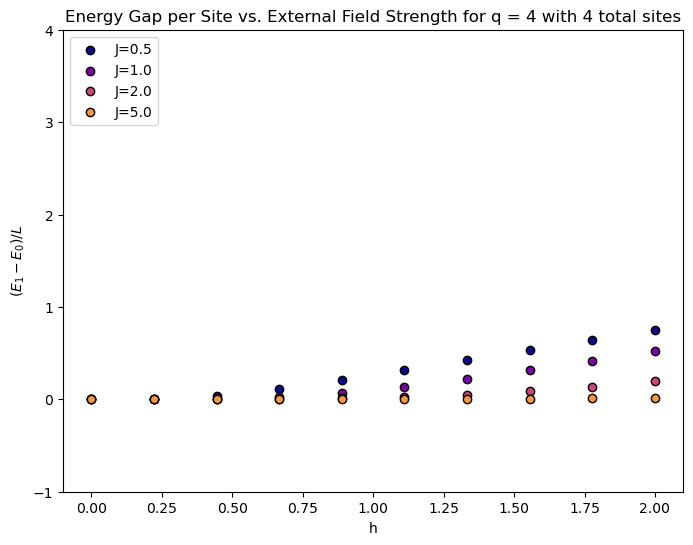

Total runtime: 4.93 seconds


In [32]:
# Parameters
L = 4
q = 4
J_values = [0.5, 1.0, 2.0, 5.0]
h_values = np.linspace(0, 2, 10)  # Range of h values

start_time = time.time()

# Total unique combinations
total_combinations = len(J_values)

plt.figure(figsize = (8, 6))
# Get colormap and generate distinct colors
cmap = plt.colormaps.get_cmap("plasma")  # Get colormap
colors = [cmap(i / total_combinations) for i in range(total_combinations)]  # Generate unique colors

index = 0  # Color index tracker
for J in J_values:
    energies = [E0_and_E1_per_site(q, J, h, L) for h in h_values]
    plt.scatter(h_values, energies, color=colors[index], edgecolors="black", label=f"J={J}")
    index += 1  # Move to the next color

plt.xlabel("h")
plt.ylabel("$(E_{1} - E_{0})/ L$")
plt.title(f"Energy Gap per Site vs. External Field Strength for q = {q} with {L} total sites")
plt.ylim(-1, 4)
plt.legend(loc="upper left", bbox_to_anchor=(0, 1))
plt.show()
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

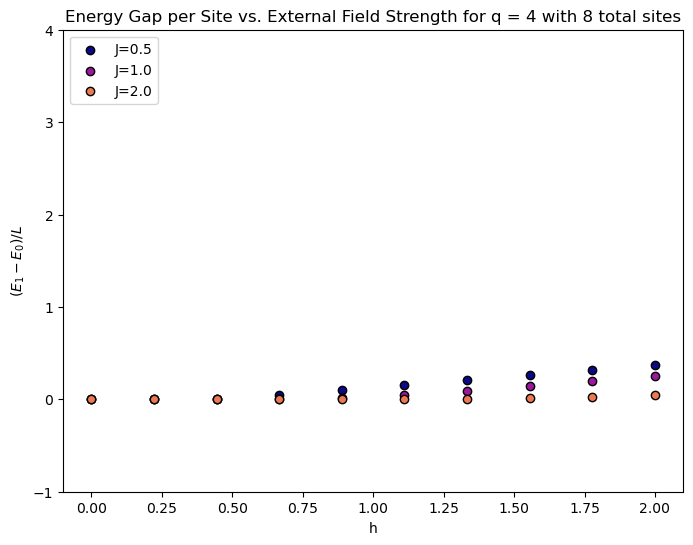

Total runtime: 200.46 seconds


In [33]:
# Parameters
L = 8
q = 4
J_values = [0.5, 1.0, 2.0]
h_values = np.linspace(0, 2, 10)  # Range of h values

start_time = time.time()

# Total unique combinations
total_combinations = len(J_values)

plt.figure(figsize = (8, 6))
# Get colormap and generate distinct colors
cmap = plt.colormaps.get_cmap("plasma")  # Get colormap
colors = [cmap(i / total_combinations) for i in range(total_combinations)]  # Generate unique colors

index = 0  # Color index tracker
for J in J_values:
    energies = [E0_and_E1_per_site(q, J, h, L) for h in h_values]
    plt.scatter(h_values, energies, color=colors[index], edgecolors="black", label=f"J={J}")
    index += 1  # Move to the next color

plt.xlabel("h")
plt.ylabel("$(E_{1} - E_{0})/ L$")
plt.title(f"Energy Gap per Site vs. External Field Strength for q = {q} with {L} total sites")
plt.ylim(-1, 4)
plt.legend(loc="upper left", bbox_to_anchor=(0, 1))
plt.show()
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

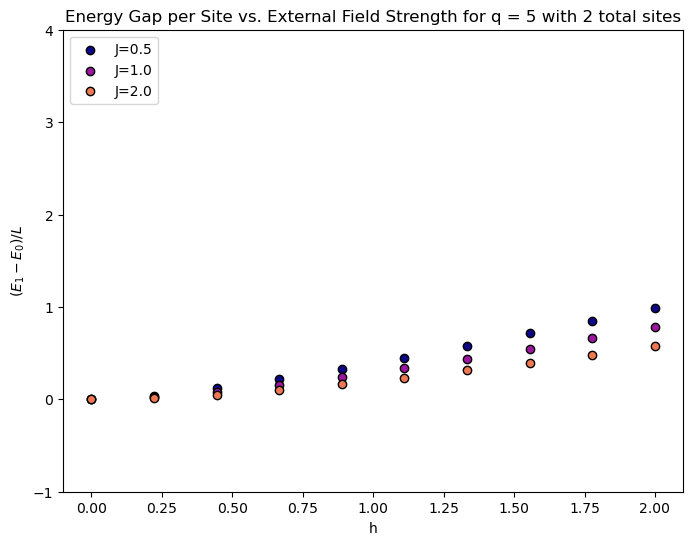

Total runtime: 1.33 seconds


In [34]:
# Parameters
L = 2
q = 5
J_values = [0.5, 1.0, 2.0]
h_values = np.linspace(0, 2, 10)  # Range of h values

start_time = time.time()

# Total unique combinations
total_combinations = len(J_values)

plt.figure(figsize = (8, 6))
# Get colormap and generate distinct colors
cmap = plt.colormaps.get_cmap("plasma")  # Get colormap
colors = [cmap(i / total_combinations) for i in range(total_combinations)]  # Generate unique colors

index = 0  # Color index tracker
for J in J_values:
    energies = [E0_and_E1_per_site(q, J, h, L) for h in h_values]
    plt.scatter(h_values, energies, color=colors[index], edgecolors="black", label=f"J={J}")
    index += 1  # Move to the next color

plt.xlabel("h")
plt.ylabel("$(E_{1} - E_{0})/ L$")
plt.title(f"Energy Gap per Site vs. External Field Strength for q = {q} with {L} total sites")
plt.ylim(-1, 4)
plt.legend(loc="upper left", bbox_to_anchor=(0, 1))
plt.show()
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

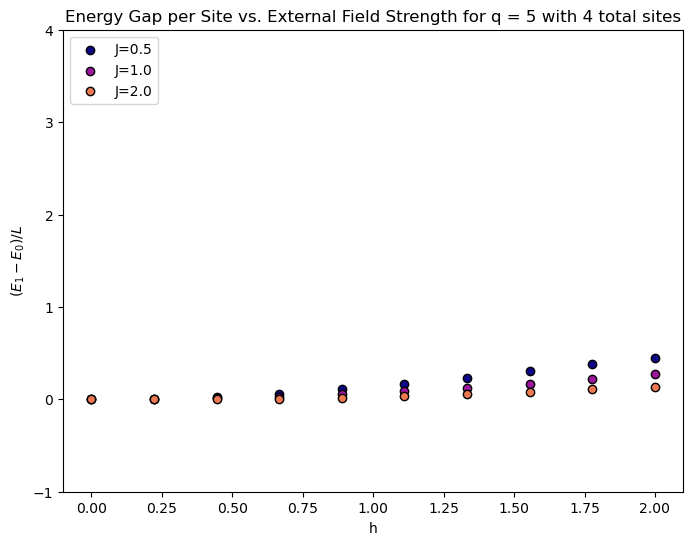

Total runtime: 4.06 seconds


In [35]:
# Parameters
L = 4
q = 5
J_values = [0.5, 1.0, 2.0]
h_values = np.linspace(0, 2, 10)  # Range of h values

start_time = time.time()

# Total unique combinations
total_combinations = len(J_values)

plt.figure(figsize = (8, 6))
# Get colormap and generate distinct colors
cmap = plt.colormaps.get_cmap("plasma")  # Get colormap
colors = [cmap(i / total_combinations) for i in range(total_combinations)]  # Generate unique colors

index = 0  # Color index tracker
for J in J_values:
    energies = [E0_and_E1_per_site(q, J, h, L) for h in h_values]
    plt.scatter(h_values, energies, color=colors[index], edgecolors="black", label=f"J={J}")
    index += 1  # Move to the next color

plt.xlabel("h")
plt.ylabel("$(E_{1} - E_{0})/ L$")
plt.title(f"Energy Gap per Site vs. External Field Strength for q = {q} with {L} total sites")
plt.ylim(-1, 4)
plt.legend(loc="upper left", bbox_to_anchor=(0, 1))
plt.show()
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

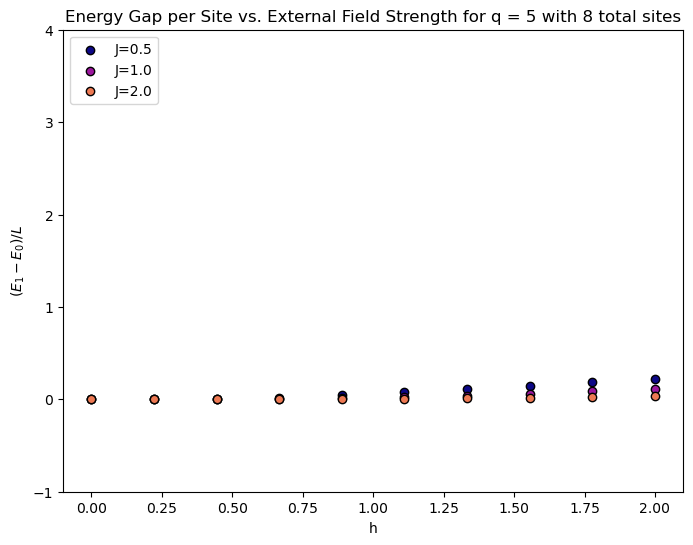

Total runtime: 830.13 seconds


In [36]:
# Parameters
L = 8
q = 5
J_values = [0.5, 1.0, 2.0]
h_values = np.linspace(0, 2, 10)  # Range of h values

start_time = time.time()

# Total unique combinations
total_combinations = len(J_values)

plt.figure(figsize = (8, 6))
# Get colormap and generate distinct colors
cmap = plt.colormaps.get_cmap("plasma")  # Get colormap
colors = [cmap(i / total_combinations) for i in range(total_combinations)]  # Generate unique colors

index = 0  # Color index tracker
for J in J_values:
    energies = [E0_and_E1_per_site(q, J, h, L) for h in h_values]
    plt.scatter(h_values, energies, color=colors[index], edgecolors="black", label=f"J={J}")
    index += 1  # Move to the next color

plt.xlabel("h")
plt.ylabel("$(E_{1} - E_{0})/ L$")
plt.title(f"Energy Gap per Site vs. External Field Strength for q = {q} with {L} total sites")
plt.ylim(-1, 4)
plt.legend(loc="upper left", bbox_to_anchor=(0, 1))
plt.show()
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")